### Materials and Methods


#### 3.1. Materials

Data for the seven metrics was accumulated from various open-source databases as listed in Fig 1. below.

In [2]:
# I'm working in a Python Virtual Environment. If you do too, you might need to install the following packages.

#!pip install missingno
#!pip install -U scikit-learn
#!pip install scipy
#!pip install seaborn
#!pip install pandas
#!pip install matplotlib
#!pip install statsmodels
#!pip install fancyimpute
#!pip install nbconvert[qtpdf]

In [3]:
# Importing the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import stats
from fancyimpute import KNN
from fancyimpute import IterativeImputer
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder

In [4]:
# The table of indicators
the_metrics = [
    ['Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Food Nutrient Adequacy', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Ecosystem Stability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Food Affordability & Availability', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Socialcultural Wellbeing', 'Resilience', 'Resilience', 'Food Safety', 'Food Safety', 'Waste & Loss Reduction'],
    ['Non-Staple Food Energy', 'Shannon Diversity', 'Modified Functional Attribute Diversity', 'Nutrient Density Score', 'Population Share With Adequate Nutrients', 'Ecosystem Status', 'GHG Emissions', 'Net FreshWater Withdrawals', 'Energy Use', 'Land Use', 'Income Equality', 'Poverty Index', 'GFSI Food Availability Score', 'Food Affordability', 'Animal Health & Welfare', 'Community Rights', ' Child Labor', 'Gender Equity', 'Food Production Diversity', 'ND-GAIN Country Index', 'GFSI Safety Score', 'Foodborne Disease Burden', 'Pre & Post-Consumer Food Loss'],
    ['Nutrients From Non-Staple Food', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Nutrient Diversity in The Food System', 'Proportion of Population With Adequate Nutrients', 'Ecosystem Status', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Eco-Efficiency', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Food Availability & Affordability', 'Gender Equality', 'Extent of Child Labor', 'Respect for Community Rights', 'Animal Health & Welfare', "Nation's Vulnerability to Climate Change", "Shares of Agricultural Food Production in The Country", "Food Borne Disease Burden", "GFSI Food Safety", "Later"]
]

sources = [['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'], ['FAOs Food Balance Sheets'],['FAOs Food Balance Sheets'], ['FAOSTATS'], ['Yale Center for Environmental Law and Policy'], ['United Nations Framework Convention on Climate Change'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Data Collections, NASA'], ['Global Food Security Index (GFSI)'], ['Global Food Security Index (GFSI)'], ['United Nations, 2021'], ['United Nations, 2021'], ['Global Gender Gap Report 2020'], ['ILO, 2020'], ['Environmental Democracy Index'], ['Not Measured (Insufficient Data)'], ["Notre Dame Global Adaptation Initiative"], ["FAOSTAT"], ["World Health Organisation (WHO)"], ["Global Food Security Index (GFSI)"], ["Later"]]


the_table = pd.DataFrame(sources,
                         index= the_metrics,
                         columns = ["Sources"]
                        )

the_table.index = the_table.index.rename(['The Metric', 'Indicators', 'What They Measure'])

the_table.style

#the_table.to_csv('The Metrics.csv')

##### 3.1.1. Food Nutrient Adequacy

##### Non-Staple Food Energy

The data for this indicator was taken from [FAO's food balance sheets](https://www.fao.org/faostat/en/#data/FBS). It contained the per capita daily energy intake from 98 types of foods in 186 countries globally. Preliminary examination of the data showed a small to moderate amount of missing data from each item (0 - 20%<cite id="ggjuc">(Hair et al., 1998)</cite>, refer Fig...). Due to the data being Missing Completely At Random (MCAR), a relatively small amount of missing values for most food items, and the fact that each country had at least one item with missing data, a replacement of 0 for each missing value was done. The resulting dataset was aggregated such that each of the 98 food item's daily calory intake was aggregated into one of the following major food types; Cereals, Roots and Tubers, Meat and Milk products and eggs, Fruits and Plantains, Vegetables, Seeds and Nuts and Oil, Starchs and Sugars, and Infant Foods <cite id="dp2pf">({\em Dimensions of Need - Staple Foods: What Do People Eat?}, n.d.)</cite> and <cite id="djtpj">(Gustafson et al., 2016)</cite>. The resulting dataset had values from 46 high income countries, 21 low income, 44 lower middle income, and 45 upper middle income (Fig...). Further exploration of the dataset revealed extreme values among different food groups in different income groups. To maintain a robust sample size, median was selected as the measure of central tendency to measure the contribution of each food group in daily calory intake from each income group. The median values, after being processed into percentage values, were filtered to include food groups whose median daily calory intake represented anything less than 15 percent of total median calory intake from the particular income group. It was selected so, bearing in mind the insights derived from the dataset itself and official definitions of staple foods as defined by <cite id="2mvz2">(Mäkelä & Rautavirta, 2018)</cite> and <cite id="l1hpk">({\em Dimensions of Need - Staple Foods: What Do People Eat?}, n.d.)</cite>. The results are presented in Fig..., where the daily median calorie intake from each of the 8 major food groups is presented, together with the classification of whether the food group is a staple for that particular income group or not.

/tmp/ipykernel_143242/510776734.py:69: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  percentage_of_nullity = size_and_dietary_intake.groupby('Income group').sum()\


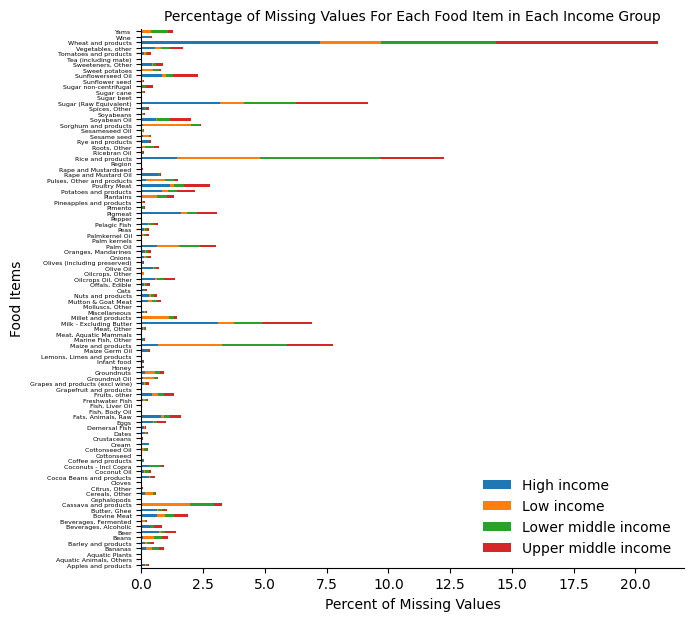

In [5]:
# 1. Loading the 'Country_Groups' Data Set
size_of_economy = pd.read_csv('Country_Groups.csv', sep = ",", \
                  header = 0, usecols = ["Country","Income group", \
                  "Region"]).set_index('Country')

#display(size_of_economy.head(15))



# 2. Displaying the count of countries in each country group.

counts = pd.DataFrame(size_of_economy['Income group'].value_counts())

counts.loc['Total'] = counts['Income group'].sum()

#display(counts)



# 3. Loading the Dataset

dietary_intake = pd.read_csv("Daily_Energy_Intake.csv", 
                		sep= ',', 
                		header= None,
                        skiprows= [0],
                        names= ['Country', 'Food', 'Value'],
                        usecols= [0, 1, 2],
                            )
#display(dietary_intake.head())



# 4. Transposing the 2nd column to work with the data easily.

dietary_intake_transposed = dietary_intake.pivot_table(
	index= 'Country',
    columns= 'Food',
    values = 'Value'
)
    
#display(dietary_intake_transposed.info())    
#print(dietary_intake_transposed.columns)



# 5. Checking the data type
#display(dietary_intake_transposed.info())




# 6. Merging countries and their sizes of economies:  
size_and_dietary_intake = pd.merge(size_of_economy,
                                        dietary_intake_transposed,
                                        left_index=True,
                                        right_index= True)

#display(size_of_econ_and_diet_intake.head())




# 7. Checking the Type and Extent of Missing Data

dietary_intake_nullity = size_and_dietary_intake.isnull()

#display(dietary_intake_nullity)

percentage_of_nullity = size_and_dietary_intake.groupby('Income group').sum()\
                        .div(size_and_dietary_intake.groupby('Income group')\
                             .count() * 100)



# 8. Visualizing Nullity
percentage_of_nullity_dietary_intake_transposed = percentage_of_nullity.T

ax = percentage_of_nullity_dietary_intake_transposed.plot(kind='barh',
                                                          stacked=True)

ax.figure.set_size_inches(7, 7)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='lower right', frameon=False)
#ax.invert_yaxis()
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' : 10})
ax.tick_params(axis='y', which= 'major', labelsize=4.5)

#plt.set_size_inches(9, 7)
#plt.savefig('Percent_of_Nullity_1st_indicator.png')
plt.show()


#pd.DataFrame(size_and_dietary_intake.columns).to_csv('Food Items.csv', index=True)

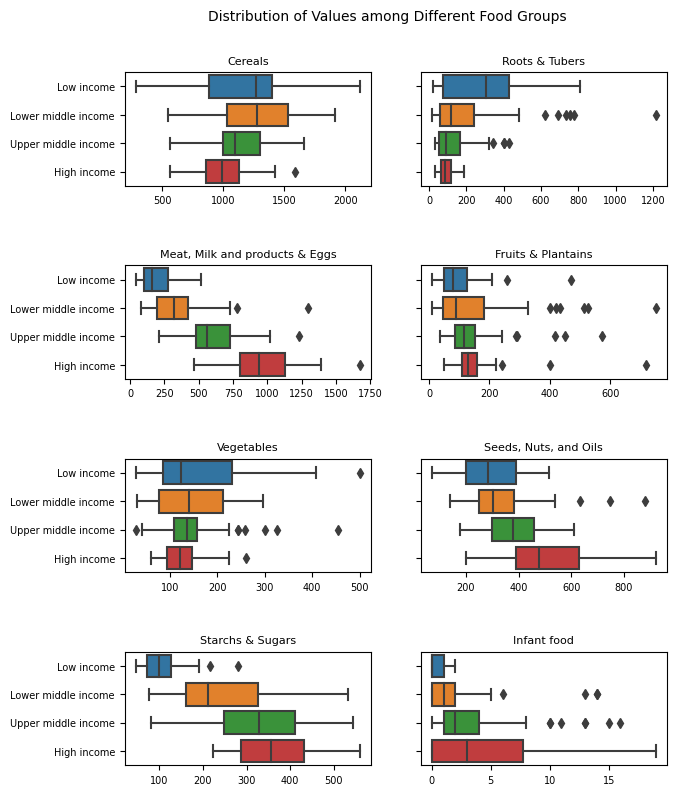

In [6]:
# 9. Cleaning the dataset
# 9.1. Replacing 'NaN's with 0's
size_and_dietary_intake_imputed = size_and_dietary_intake.fillna(0) 	#print(the_sheet.head())


# 9.2. Grouping the foods into 7 groups : "Cereals", "Roots & Tubers", "Meat, Milk and Products, Eggs", "Vegetables", "Fruits and Plantains", "Seeds, Nuts and Oils", "Starch and Sugars"

daily_intake_aggregated = {
    'Country' : size_and_dietary_intake_imputed.index,
    'Income group' : size_and_dietary_intake_imputed['Income group'].values,
    #'Region' : size_and_dietary_intake_imputed['Region'].values,
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Meat, Milk and products & Eggs' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starchs & Sugars' : 0
}



daily_intake_aggregated['Cereals'] = \
    	size_and_dietary_intake_imputed['Barley and products']+ \
    	size_and_dietary_intake_imputed['Cereals, Other']+ \
        size_and_dietary_intake_imputed['Maize and products']+ \
        size_and_dietary_intake_imputed['Millet and products']+ \
        size_and_dietary_intake_imputed['Oats']+ \
        size_and_dietary_intake_imputed['Rice and products']+ \
        size_and_dietary_intake_imputed['Rye and products']+ \
        size_and_dietary_intake_imputed['Sorghum and products'] + \
        size_and_dietary_intake_imputed['Wheat and products']
        
daily_intake_aggregated['Roots & Tubers'] = \
    	size_and_dietary_intake_imputed['Cassava and products']+ \
        size_and_dietary_intake_imputed['Potatoes and products']+ \
        size_and_dietary_intake_imputed['Roots, Other']+ \
        size_and_dietary_intake_imputed['Sweet potatoes']+ \
    	size_and_dietary_intake_imputed['Yams'] + \
    	size_and_dietary_intake_imputed['Sugar cane'] + \
        size_and_dietary_intake_imputed['Sugar beet']

        
daily_intake_aggregated['Meat, Milk and products & Eggs'] = \
    	size_and_dietary_intake_imputed['Bovine Meat']+ \
    	size_and_dietary_intake_imputed['Butter, Ghee']+ \
    	size_and_dietary_intake_imputed['Cephalopods']+ \
    	size_and_dietary_intake_imputed['Cream']+ \
    	size_and_dietary_intake_imputed['Crustaceans']+ \
        size_and_dietary_intake_imputed['Offals, Edible'] + \
        size_and_dietary_intake_imputed['Demersal Fish'] + \
    	size_and_dietary_intake_imputed['Eggs'] + \
        size_and_dietary_intake_imputed['Fats, Animals, Raw'] + \
        size_and_dietary_intake_imputed['Fish, Body Oil'] + \
        size_and_dietary_intake_imputed['Fish, Liver Oil'] + \
        size_and_dietary_intake_imputed['Freshwater Fish'] + \
        size_and_dietary_intake_imputed['Meat, Other'] + \
        size_and_dietary_intake_imputed['Marine Fish, Other'] + \
    	size_and_dietary_intake_imputed['Meat, Aquatic Mammals'] + \
    	size_and_dietary_intake_imputed['Milk - Excluding Butter']+ \
    	size_and_dietary_intake_imputed['Molluscs, Other']+ \
    	size_and_dietary_intake_imputed['Poultry Meat']+ \
    	size_and_dietary_intake_imputed['Mutton & Goat Meat'] + \
        size_and_dietary_intake_imputed['Pelagic Fish'] + \
        size_and_dietary_intake_imputed['Aquatic Animals, Others'] + \
        size_and_dietary_intake_imputed['Pigmeat']

daily_intake_aggregated['Vegetables'] = \
    	size_and_dietary_intake_imputed['Beans']+ \
        size_and_dietary_intake_imputed['Pimento'] + \
        size_and_dietary_intake_imputed['Spices, Other'] + \
        size_and_dietary_intake_imputed['Pepper'] + \
    	size_and_dietary_intake_imputed['Onions']+ \
    	size_and_dietary_intake_imputed['Pulses, Other and products']+ \
    	size_and_dietary_intake_imputed['Soyabeans']+ \
    	size_and_dietary_intake_imputed['Vegetables, other'] + \
    	size_and_dietary_intake_imputed['Tea (including mate)'] + \
    	size_and_dietary_intake_imputed['Tomatoes and products'] + \
        size_and_dietary_intake_imputed['Peas'] + \
    	size_and_dietary_intake_imputed['Aquatic Plants'] + \
        size_and_dietary_intake_imputed['Cloves']
    
daily_intake_aggregated['Fruits & Plantains'] = \
    	size_and_dietary_intake_imputed['Bananas']+ \
    	size_and_dietary_intake_imputed['Coconuts - Incl Copra']+ \
    	size_and_dietary_intake_imputed['Dates']+ \
    	size_and_dietary_intake_imputed['Fruits, other']+ \
    	size_and_dietary_intake_imputed['Grapefruit and products'] + \
    	size_and_dietary_intake_imputed['Grapes and products (excl wine)'] + \
    	size_and_dietary_intake_imputed['Lemons, Limes and products'] + \
    	size_and_dietary_intake_imputed['Oranges, Mandarines'] + \
    	size_and_dietary_intake_imputed['Pineapples and products'] + \
    	size_and_dietary_intake_imputed['Plantains'] + \
    	size_and_dietary_intake_imputed['Apples and products'] + \
        size_and_dietary_intake_imputed['Citrus, Other']
    
daily_intake_aggregated['Seeds, Nuts, and Oils'] = \
    	size_and_dietary_intake_imputed['Cocoa Beans and products'] + \
        size_and_dietary_intake_imputed['Maize Germ Oil'] + \
        size_and_dietary_intake_imputed['Nuts and products'] + \
    	size_and_dietary_intake_imputed['Coconut Oil'] + \
        size_and_dietary_intake_imputed['Coconuts - Incl Copra'] + \
    	size_and_dietary_intake_imputed['Coffee and products'] + \
    	size_and_dietary_intake_imputed['Cottonseed Oil'] + \
    	size_and_dietary_intake_imputed['Cottonseed'] + \
        size_and_dietary_intake_imputed['Ricebran Oil'] + \
    	size_and_dietary_intake_imputed['Groundnut Oil'] + \
        size_and_dietary_intake_imputed['Oilcrops Oil, Other'] + \
    	size_and_dietary_intake_imputed['Groundnuts'] + \
        size_and_dietary_intake_imputed['Olive Oil'] + \
        size_and_dietary_intake_imputed['Olives (including preserved)'] + \
    	size_and_dietary_intake_imputed['Oilcrops, Other'] + \
    	size_and_dietary_intake_imputed['Palmkernel Oil'] + \
    	size_and_dietary_intake_imputed['Palm Oil'] + \
    	size_and_dietary_intake_imputed['Palm kernels'] + \
    	size_and_dietary_intake_imputed['Rape and Mustard Oil'] + \
    	size_and_dietary_intake_imputed['Rape and Mustardseed'] + \
    	size_and_dietary_intake_imputed['Sesame seed'] + \
    	size_and_dietary_intake_imputed['Sesameseed Oil'] + \
    	size_and_dietary_intake_imputed['Soyabean Oil'] + \
    	size_and_dietary_intake_imputed['Sunflower seed'] + \
    	size_and_dietary_intake_imputed['Sunflowerseed Oil']
    	#the_sheet_transposed['Nuts and products [2551]'] + \
    
daily_intake_aggregated['Starchs & Sugars'] = \
    	size_and_dietary_intake_imputed['Honey'] + \
    	size_and_dietary_intake_imputed['Sugar (Raw Equivalent)'] + \
    	size_and_dietary_intake_imputed['Sugar non-centrifugal'] + \
    	size_and_dietary_intake_imputed['Sweeteners, Other'] + \
    	size_and_dietary_intake_imputed['Beverages, Fermented']

daily_intake_aggregated['Infant food'] = \
        size_and_dietary_intake_imputed['Infant food']



daily_dietary_intake = pd.DataFrame(daily_intake_aggregated).set_index('Country')


#display(daily_dietary_intake.head())
#daily_dietary_intake.to_csv('Daily Dietary Energy Intake.csv', index=True)




## 9.3. Checking Extreme Values

def income_group_separator(df, col, cat) :

    """Separates a respective income group's data"""
    
    new_df = df[df[col] == cat]
    
    return new_df

low_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'Low income')

lower_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Lower middle income')

upper_middle_values = income_group_separator(daily_dietary_intake,'Income group', 'Upper middle income')

high_inc_values = income_group_separator(daily_dietary_intake, 'Income group', 'High income')

#display(high_inc_values.head())

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharey=True, sharex=False, figsize=(7, 9))

def distributions(df, x, y, ax) :
    
    """Plots Boxplots for income groups"""
    
    g = sns.boxplot(data=df,
                    ax= ax,
                    x=x,
                    palette='tab10',
                    y=y).set(xlabel='',
                             ylabel='',
                             title=x)
    
    ax.set_title(x, fontsize=8)
    
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    return g


#display(daily_dietary_intake.groupby('Income group').count())

distributions(df=daily_dietary_intake, x='Cereals', y='Income group', ax=ax1)
distributions(df=daily_dietary_intake, y='Income group', x='Roots & Tubers', ax=ax2)
distributions(df=daily_dietary_intake, y='Income group', x='Meat, Milk and products & Eggs', ax=ax3)
distributions(df=daily_dietary_intake, y='Income group', x='Vegetables', ax=ax5)
distributions(df=daily_dietary_intake, y='Income group', x='Fruits & Plantains', ax=ax4)
distributions(df=daily_dietary_intake, y='Income group', x='Seeds, Nuts, and Oils', ax=ax6)
distributions(df=daily_dietary_intake, y='Income group', x='Starchs & Sugars', ax=ax7)
distributions(df=daily_dietary_intake, y='Income group', x='Infant food', ax=ax8)


plt.suptitle('Distribution of Values among Different Food Groups', y= 0.95, fontsize=10)
plt.subplots_adjust(hspace= 0.7)
#plt.savefig('Distribution_of_Daily_Kcal_Intakes.png')

#daily_dietary_intake.groupby('Income group').count().to_csv('Count_of_countries_Median_dietary_Intake.csv')

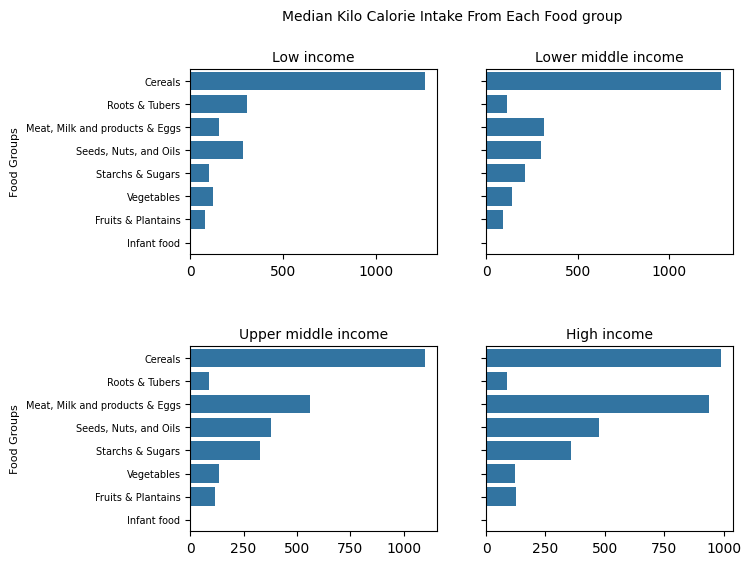

In [7]:
# 10. Preparing to extract dietary values from foods that are not staples.

## 10.1. Aggregating the data according to income groups

daily_intake_economized = daily_dietary_intake.groupby('Income group')

median_kilo_calories_by_income_group = daily_intake_economized.median()



## 10.2. Visualizing median kilo calories from each income group.

## Transposing so that one can plot
median_kilo_cal_transposed = median_kilo_calories_by_income_group.T

#display(daily_dietary_intake.head(10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=True)
fig.set_size_inches(7, 6)

palette= ['#1f77b4']


def bar_plotter(df, x, y, ax, xlabel=None, ylabel=None) :
    
    """Creates bar plots for Income groups"""
    
    g = sns.barplot(x=x,
                    y=y,
                    data= df,
                    ax= ax,
                    palette=palette).set(xlabel='')


    ax.tick_params(axis= 'y', which='major', labelsize=7)
    ax.set_ylabel(ylabel, fontdict={"fontsize" : 8})
    ax.set_xlabel(xlabel, fontdict={'fontsize' : 8})
    ax.set_title(label=x, fontsize=10)
    plt.subplots_adjust(hspace=0.5)



df = median_kilo_cal_transposed

y = median_kilo_cal_transposed.index

yl = 'Food Groups'


bar_plotter(df, x='Low income', y=y, ax=ax1, ylabel=yl)

bar_plotter(df, x='Lower middle income', ax=ax2, y=y)

bar_plotter(df, x='Upper middle income', ax=ax3, y=y, ylabel=yl)

bar_plotter(df, x='High income', y=y, ax=ax4)


plt.suptitle('Median Kilo Calorie Intake From Each Food group', fontsize=10)
plt.savefig('Median Daily_Intake_Kcal.png')
plt.show()

In [8]:
median_kcal_high_income = median_kilo_cal_transposed[['High income']].sort_values('High income', ascending=False)

median_kcal_low_income = median_kilo_cal_transposed[['Low income']].sort_values('Low income' , ascending=False)

median_kcal_lower_middle_income = median_kilo_cal_transposed[['Lower middle income']].sort_values('Lower middle income', ascending=False)

median_kcal_upper_middle_income = median_kilo_cal_transposed[['Upper middle income']].sort_values('Upper middle income', ascending=False)


def percentage_cal(df) :
    
    """Calculates Percentage For Each Food Group"""

    df.loc['Total'] = df.iloc[:, 0].sum()

    numerator = df.iloc[:, 0].values

    denominator = df.loc['Total'].values

    df['Percent'] = np.round(((numerator / denominator) * 100), 1)
    
    return df




food_group_kcal_percent_high_income = percentage_cal(median_kcal_high_income)

food_group_kcal_percent_low_income = percentage_cal(median_kcal_low_income)

food_group_kcal_percent_lower_middle = percentage_cal(median_kcal_lower_middle_income)

food_group_kcal_percent_upper_middle = percentage_cal(median_kcal_upper_middle_income)


#display(food_group_kcal_percent_high_income)
#display(food_group_kcal_percent_low_income)
#display(food_group_kcal_percent_lower_middle)
#display(food_group_kcal_percent_upper_middle)



# 11. Extracting median daily calory intake from different non-staple food groups

daily_calories_non_staples_low_income = food_group_kcal_percent_low_income[food_group_kcal_percent_low_income['Percent'] <= 15]

daily_calories_non_staples_high_income = food_group_kcal_percent_high_income[food_group_kcal_percent_high_income['Percent'] <= 15]

daily_calories_non_staples_lower_middle = food_group_kcal_percent_lower_middle[food_group_kcal_percent_lower_middle['Percent'] <= 15]

daily_calories_non_staples_upper_middle = food_group_kcal_percent_upper_middle[food_group_kcal_percent_upper_middle['Percent'] <= 15] 


#display(daily_calories_non_staples_low_income)
#display(daily_calories_non_staples_lower_middle)
#display(daily_calories_non_staples_upper_middle)
#display(daily_calories_non_staples_high_income)


intake_percent_table_index = [
    ['Low Income', 'Low Income', 'Low Income', 'Low Income', 'Low Income', 'Low Income', 'Low Income', 'Lower Middle Income', 'Lower Middle Income', 'Lower Middle Income', 'Lower Middle Income', 'Lower Middle Income', 'Lower Middle Income', 'Lower Middle Income', 'Upper Middle Income', 'Upper Middle Income', 'Upper Middle Income', 'Upper Middle Income', 'Upper Middle Income', 'Upper Middle Income', 'High Income', 'High Income', 'High Income', 'High Income', 'High Income'],
    ['Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Cereals', 'Meat, Milk and products & Eggs', 'Meat, Milk and products & Eggs', 'Meat, Milk and products & Eggs', 'Cereals', 'Cereals', 'Meat, Milk and products & Eggs', 'Seeds, Nuts, and Oils', 'Seeds, Nuts, and Oils'],
    ['54.6', '54.6', '54.6', '54.6', '54.6', '54.6', '54.6', '52.1', '52.1', '52.1', '52.1', '52.1', '52.1', '52.1', '40.6', '40.6', '40.6', '20.7', '20.7', '20.7', '31.9', '31.9', '30.3', '15.4', '15.4'],
    ['Roots & Tubers', 'Seeds, Nuts, and Oils', 'Meat, Milk and products & Eggs', 'Vegetables', 'Starch & Sugars', 'Fruits & Plantains', 'Infant Food', 'Meat, Milk and products & Eggs', 'Seeds, Nuts, and Oils', 'Starchs & Sugars', 'Vegetables', 'Roots & Tubers', 'Fruits & Plantains', 'Infant Food', 'Seeds, Nuts, and Oils', 'Starchs & Sugars', 'Vegetables', 'Fruits & Plantains', 'Roots & Tubers', 'Infant Food', 'Starchs & Sugars', 'Fruits & Plantains', 'Vegetables', 'Roots & Tubers', 'Infant Food'],
]


intake_percent_table_column = ['13.2', '12.3', '6.8', '5.3', '4.3', '3.5', '0.0', '12.9', '12.2', '8.6', '5.7', '4.7', '3.7', '0.0', '13.9', '12.2', '5.0', '4.3', '3.3', '0.1', '11.5', '4.1', '3.9', '2.8', '0.1']

#display(len(intake_percent_table_column))

intake_percent_table = pd.DataFrame(intake_percent_table_column,
                                    index=intake_percent_table_index,
                                    columns=['Percent of Median Calorie Intake'])

intake_percent_table.index = intake_percent_table.index.rename(['Income group', 'Staple Foods', 'Percent of Median Daily Calorie Intake', 'Non-Staple Foods'])

display(intake_percent_table.style)

#intake_percent_table.to_csv('Daily_Median_Percent_Intakes.csv', index=True)

###### Shannon Diversity

This indicator measures diversity of nutrients in a food system by measuring the quantity in weight of various food items available in a food system. Data for the annual per capita quantity supply of food items in countries globally, in-terms of weight, is readly available at FAO <cite id="v6csd">({\em FAOSTAT}, n.d.)</cite>. Data for similar food items as the ones used in the first indicator was obtained from FAO's food balance sheets. A preliminary examination of the data showed considerable missing values in some food items, and here, like in the previous indicator, the type and extent of missing data, together with previous knowledge on the domain of subject, determined the method of handling missing data. The type of missing data was both MAR (Missing at Random) and MNAR (Missing Not At Random), as some food items such as *non-centrifugal sugars* have a high percentage of missingness in all four income groups, suggesting there being some reporting problems that caused the data for both 4 income groups to be missing (hence MNAR), and some, such as *millet and products*, have a high percentage of missingness in only three groups (High income, Low middle income and Upper middle income), suggesting that there is another factor influencing the missingness of this variable (hence MAR). It was decided to remove all food items with more than 40% of missing data in any of the 4 income groups as practical recommendation from <cite id="evyja">({\em What Should Be the Allowed Percentage of Missing Values?}, 2015)</cite> and <cite id="e6lck">(Hair et al., 2018)</cite> suggest. Imputation was done using the MICE and KNN multiple-imputation methods, and the results of the R statistic were compared to each other. The figure below shows the percentage of missing data from each food group (figure...) and the KNN, MICE R-statistic comparison. Imputation by using MICE proved to be more robust (with the adjusted R-square of 0.89), and thus the dataset imputed by using it was the one used for the next procedures of data preparation. The data was then aggregated into seven food groups, as the one used in the first indicator, and then it was ready for the next stage of the analysis.

In [9]:
# 1. Reading-in the dataset from FAO

food_supply = pd.read_csv('Food Quantity Data.csv',
                          sep= ',',
                          names= ['Country', 'Item', 'Value'])

#display(food_supply.head(30))

copy_food_supply = food_supply.copy(deep= True).drop(0)

#display(copy_food_supply.head(10))



# 2. Transposing the Data so that each country is represented as a one row:
transposed_copy_of_food_supply = copy_food_supply.pivot(
    index= 'Country',
    columns= 'Item',
    values= 'Value'
)
#display(transposed_copy_of_food_supply.head(1))
#display(transposed_copy_of_food_supply.info())




# 3. Changing the data type. Data in all columns was as objects, not numbers.
transposed_copy_copy = transposed_copy_of_food_supply.copy(deep= True)#.fillna(0)

transposed_copy_cleaned = transposed_copy_copy.loc[:,:].astype('float')

#assert transposed_copy_cleaned.loc[:,:].dtype == 'float'

#display(transposed_copy_cleaned.head())




# 4. Attaching countries' regions and sizes of economy
transposed_copy_with_size_and_region = pd.merge(size_of_economy,
                                                transposed_copy_cleaned,
                                                left_index=True,
                                                right_index=True
                                               )

#display(transposed_copy_with_size_and_region)




# 5. Dealing with Missing Data: Determining the type.

## 5.1. Checking to see if there is any relationship between income group and missing data on a specific food item:

transposed_copy_nullity = transposed_copy_cleaned.isnull()

#display(transposed_copy_nullity)

transposed_copy_nullity_with_regions = pd.merge(size_of_economy,
                                                transposed_copy_nullity,
                                                left_index=True,
                                                right_index=True
                                               )
#display(transposed_copy_nullity_with_regions.head())

country_count_each_inc_group = pd.DataFrame(transposed_copy_with_size_and_region['Income group'].value_counts())

country_count_each_inc_group.columns = ['Total Count']
#display(country_count_each_inc_group)

/tmp/ipykernel_143242/2730793477.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nullity_by_income_group = transposed_copy_nullity_with_regions.groupby('Income group').sum()


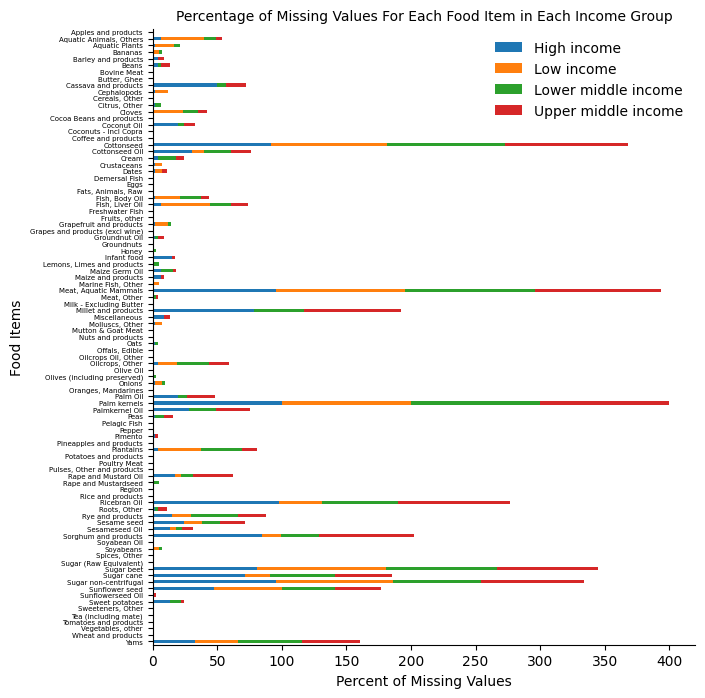

In [10]:
## 5.2. Percentage of missing values for each food group in each income group
nullity_by_income_group = transposed_copy_nullity_with_regions.groupby('Income group').sum()

count_of_countries = transposed_copy_nullity_with_regions.groupby('Income group').count()

percentage_of_nullity_of_food_groups = nullity_by_income_group.div(count_of_countries) * 100

#display(percentage_of_nullity)

percentage_of_nullity_of_food_groups_pivoted = percentage_of_nullity_of_food_groups.T

#display(percentage_of_nullity_of_food_groups_pivoted)



## 5.3. Visualizing Missingness

#fig = plt.figure()
#fig.set_size_inches(10, 7)

ax = percentage_of_nullity_of_food_groups_pivoted.plot(kind= 'barh',
                                  stacked=True)

ax.figure.set_size_inches(7, 8)
ax.set(xlabel='Percent of Missing Values',
       ylabel='Food Items')
ax.legend(loc='upper right', frameon=False)
for spine in ['top', 'right'] :
    ax.spines[spine].set_visible(False)
ax.set_title('Percentage of Missing Values For Each Food Item in Each Income Group', fontdict={'fontsize' :10})
ax.tick_params(axis='y', which= 'major', labelsize=5)
ax.invert_yaxis()

In [11]:
## 5.4. Encoding the categorical values of Region and Size of Economy:  

### 5.4.1. Making sure there aren't any missing values

regions_nullity = transposed_copy_with_size_and_region['Region'].isnull()

size_of_economy_nullity = transposed_copy_with_size_and_region['Income group'].isnull()

#print("Region nullity: {}".format(regions_nullity.sum()))

#print("Nullity in Size of Economy / Income group: {}".format(size_of_economy_nullity.sum()))


## There was one un-classification: Venezuela
size_of_economy_missing_val = size_of_economy_nullity[size_of_economy_nullity == True]

#display(size_of_economy_missing_val)


# Removing Venezuela
#adjusted_transposed_copy = transposed_copy_with_size_and_region.drop('Venezuela, RB', axis=0)

adjusted_transposed_copy = transposed_copy_with_size_and_region

size_of_economy_nullity_updated = adjusted_transposed_copy['Income group'].isnull().sum()

#print("Updated Number of Nullity at Size of Economy / Income group: {}".format(size_of_economy_nullity_updated))




# Encoding
encoder = OrdinalEncoder()

regions = adjusted_transposed_copy['Region']

income_groups = adjusted_transposed_copy['Income group']

#display(pd.DataFrame(regions.unique()))
#display(pd.DataFrame(income_groups.unique()))

reshaped_regions = regions.values.reshape(-1, 1)

reshaped_income_groups = income_groups.values.reshape(-1, 1)

#display(reshaped_regions)

encoded_regions = encoder.fit_transform(reshaped_regions)

encoded_income_groups = encoder.fit_transform(reshaped_income_groups)
adjusted_transposed_copy_for_encoding = adjusted_transposed_copy.copy(deep=True)

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[1]] = np.squeeze(encoded_regions)
#adjusted_transposed_copy_for_encoding.loc[:, 'Region'] = np.squeeze(encoded_regions) ---> A clearer code, but results into a FutureWarning Error

adjusted_transposed_copy_for_encoding[adjusted_transposed_copy_for_encoding.columns[0]] = np.squeeze(encoded_income_groups)
#adjusted_transposed_copy_for_encoding.loc[:, 'Income group'] = np.squeeze(encoded_income_groups)

#display(adjusted_transposed_copy_for_encoding.head(10))


## 5.5. Preparing Data For Imputation

excessive_missing_values = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] > 40]

#display(excessive_missing_values.info())

items_without_excessive_missingness = percentage_of_nullity_of_food_groups_pivoted[percentage_of_nullity_of_food_groups_pivoted.iloc[:, :] < 40].dropna()

#display(items_without_excessive_missingness.info())

items_without_excessive_missingness_transposed = items_without_excessive_missingness.T

food_item_list = list(items_without_excessive_missingness_transposed.columns)

#display(food_item_list)


raw_data_for_imputation = adjusted_transposed_copy_for_encoding[food_item_list]

complete_data_for_imputation = pd.merge(adjusted_transposed_copy_for_encoding.iloc[:, 0:2],
                                        raw_data_for_imputation,
                                        left_index=True,
                                        right_index=True)

#display(complete_data_for_imputation.info())



## 5.6.1. Imputing by KNN

knn_imputer = KNN()

imputed_by_knn = pd.DataFrame(knn_imputer.fit_transform(complete_data_for_imputation),
                              columns=complete_data_for_imputation.columns)


## 5.6.2. Imputing by MICE

mice = IterativeImputer()

imputed_by_mice = np.round(pd.DataFrame(mice.fit_transform(complete_data_for_imputation),
                                        index=complete_data_for_imputation.index,
                                        columns=complete_data_for_imputation.columns), 1)


## 5.6.3. Evaluating accuracy of the two methods

# Checking the R-Statistic

# KNN_imputed:

Xknn = sm.add_constant(imputed_by_knn.iloc[:, :-1])
yknn = imputed_by_knn.iloc[:, -1]
lm_knn = sm.OLS(yknn, Xknn).fit()


# MICE_imputed:
Xmice = sm.add_constant(imputed_by_mice.iloc[:, :-1])
ymice = imputed_by_mice.iloc[:, -1]
lm_mice = sm.OLS(ymice, Xmice).fit()



r_squares = pd.DataFrame(dict(KNN_Imputed = lm_knn.rsquared,
                              MICE_Imputed = lm_mice.rsquared), 
                         index= ['Adj. Rsquared'])

coefficients = pd.DataFrame(dict(KNN_Imputed = lm_knn.params,
                                 MICE_Imputed = lm_mice.params))

coefficients_combined = pd.concat((r_squares, coefficients), axis= 0)

#display(coefficients_combined.head(2))

#coefficients_combined.to_csv('MICE_vs_KNN_2nd_indicator.csv')

Imputing row 1/156 with 10 missing, elapsed time: 0.025
Imputing row 101/156 with 4 missing, elapsed time: 0.033


In [12]:
#display(imputed_by_mice.info())

# Creating a list of Food Items. Use this as a reference when aggregating food items into food groups.
food_items = pd.DataFrame(list(imputed_by_mice.columns),
                          columns= ['Food Items'])
#food_items.to_csv('Food_Items_mod.csv', index=False)



# Combining Foods into Food Groups:
aggregated_food_supplies = {
    'Cereals' : 0,
    'Roots & Tubers' : 0,
    'Meat, Milk and Products & Eggs' : 0,
    'Vegetables' : 0,
    'Fruits & Plantains' : 0,
    'Seeds, Nuts, and Oils' : 0,
    'Starch and Sugars' : 0,
    'Infant Food' : 0
}


#aggregated_food_supplies['Income group'] = imputed_by_mice['Income group'].values.reshape(-1, 1)

aggregated_food_supplies['Cereals'] = \
        imputed_by_mice['Barley and products'] + \
        imputed_by_mice['Wheat and products'] + \
        imputed_by_mice['Cereals, Other'] + \
        imputed_by_mice['Maize and products'] + \
        imputed_by_mice['Oats'] + \
        imputed_by_mice['Rice and products'] + \
        imputed_by_mice['Rye and products']


aggregated_food_supplies['Roots & Tubers'] = \
        imputed_by_mice['Potatoes and products'] + \
        imputed_by_mice['Roots, Other'] + \
        imputed_by_mice['Sweet potatoes']


aggregated_food_supplies['Meat, Milk and Products & Eggs'] = \
        imputed_by_mice['Aquatic Animals, Others'] + \
        imputed_by_mice['Bovine Meat'] + \
        imputed_by_mice['Butter, Ghee'] + \
        imputed_by_mice['Cephalopods'] + \
        imputed_by_mice['Cream'] + \
        imputed_by_mice['Crustaceans'] + \
        imputed_by_mice['Demersal Fish'] + \
        imputed_by_mice['Eggs'] + \
        imputed_by_mice['Fats, Animals, Raw'] + \
        imputed_by_mice['Freshwater Fish'] + \
        imputed_by_mice['Marine Fish, Other'] + \
        imputed_by_mice['Meat, Other'] + \
        imputed_by_mice['Milk - Excluding Butter'] + \
        imputed_by_mice['Molluscs, Other'] + \
        imputed_by_mice['Mutton & Goat Meat'] + \
        imputed_by_mice['Pelagic Fish'] + \
        imputed_by_mice['Offals, Edible'] + \
        imputed_by_mice['Poultry Meat']
    
aggregated_food_supplies['Starch and Sugars'] = \
        imputed_by_mice['Honey'] + \
        imputed_by_mice['Sweeteners, Other'] + \
        imputed_by_mice['Sugar (Raw Equivalent)']
        
    
aggregated_food_supplies['Vegetables'] = \
        imputed_by_mice['Aquatic Plants'] + \
        imputed_by_mice['Beans'] + \
        imputed_by_mice['Cloves'] + \
        imputed_by_mice['Onions'] + \
        imputed_by_mice['Oranges, Mandarines'] + \
        imputed_by_mice['Peas'] + \
        imputed_by_mice['Pepper'] + \
        imputed_by_mice['Pimento'] + \
        imputed_by_mice['Pulses, Other and products'] + \
        imputed_by_mice['Spices, Other'] + \
        imputed_by_mice['Soyabeans'] + \
        imputed_by_mice['Vegetables, other'] + \
        imputed_by_mice['Tomatoes and products'] + \
        imputed_by_mice['Tea (including mate)']
    
aggregated_food_supplies['Fruits & Plantains'] = \
        imputed_by_mice['Apples and products'] + \
        imputed_by_mice['Bananas'] + \
        imputed_by_mice['Citrus, Other'] + \
        imputed_by_mice['Dates'] + \
        imputed_by_mice['Fruits, other'] + \
        imputed_by_mice['Grapefruit and products'] + \
        imputed_by_mice['Grapes and products (excl wine)'] + \
        imputed_by_mice['Lemons, Limes and products'] + \
        imputed_by_mice['Olives (including preserved)'] + \
        imputed_by_mice['Pineapples and products'] + \
        imputed_by_mice['Plantains']
    
    
aggregated_food_supplies['Seeds, Nuts, and Oils'] = \
        imputed_by_mice['Cocoa Beans and products'] + \
        imputed_by_mice['Coconut Oil'] + \
        imputed_by_mice['Coconuts - Incl Copra'] + \
        imputed_by_mice['Coffee and products'] + \
        imputed_by_mice['Cottonseed Oil'] + \
        imputed_by_mice['Fish, Body Oil'] + \
        imputed_by_mice['Fish, Liver Oil'] + \
        imputed_by_mice['Groundnut Oil'] + \
        imputed_by_mice['Groundnuts'] + \
        imputed_by_mice['Nuts and products'] + \
        imputed_by_mice['Maize Germ Oil'] + \
        imputed_by_mice['Oilcrops Oil, Other'] + \
        imputed_by_mice['Oilcrops, Other'] + \
        imputed_by_mice['Olive Oil'] + \
        imputed_by_mice['Palm Oil'] + \
        imputed_by_mice['Palmkernel Oil'] + \
        imputed_by_mice['Rape and Mustard Oil'] + \
        imputed_by_mice['Rape and Mustardseed'] + \
        imputed_by_mice['Sesame seed'] + \
        imputed_by_mice['Sesameseed Oil'] + \
        imputed_by_mice['Sunflowerseed Oil'] + \
        imputed_by_mice['Soyabean Oil']
    
    
aggregated_food_supplies['Infant Food'] = \
        imputed_by_mice['Infant food']



df_aggregated_food_supplies = pd.merge(adjusted_transposed_copy[['Income group', 'Region']],
                                       pd.DataFrame(aggregated_food_supplies, index=imputed_by_mice.index),
                                       left_index=True,
                                       right_index=True).sort_values('Income group')

display(df_aggregated_food_supplies.head(5))

#df_aggregated_food_supplies.head(14).to_csv('1_Aggregated_Food_Supplies.csv', index=True) 

,Income group,Region,Cereals,Roots & Tubers,"Meat, Milk and Products & Eggs",Vegetables,Fruits & Plantains,"Seeds, Nuts, and Oils",Starch and Sugars,Infant Food
Country,,,,,,,,,,
Spain,High income,Europe & Central Asia,113.1,60.3,277.9,152.2,67.9,48.5,32.5,0.4
Chile,High income,Latin America & Caribbean,153.3,57.9,173.6,81.0,56.2,10.8,41.2,0.0
Iceland,High income,Europe & Central Asia,84.4,35.6,397.5,94.3,74.7,28.0,80.6,0.3
Sweden,High income,Europe & Central Asia,115.0,53.9,316.1,104.7,44.9,21.8,46.5,0.3
Slovenia,High income,Europe & Central Asia,140.1,38.1,255.2,109.3,96.6,16.6,44.7,0.0


In [13]:
df_aggregated_food_supplies.head(14).to_csv('Aggregated_Food_Supplies.csv', index=True)

###### Modified Functional Attibutite Diversity

- This indicator measures how nutrient diverse food items are in a country.

In [65]:
# 1. Merging the Food Supply Data from FAO and the Food Composition table.

## 1.1 Taking a glimpse of the food supply data to see the names of the foods used there.

#display(imputed_by_mice.head(3))


## 1.2 Importing the Food Composition Data
food_composition_table = pd.read_csv('food_composition_data.csv')

#display(food_composition_table.head(3))


## 1.3 Copying the data before transposing the table
copy_of_food_composition_table = food_composition_table.copy(deep=True).drop('nutr_std_dev', axis=1)

#display(copy_of_food_composition_table.head())


## 1.4 Transposing the table, so that each nutrient is classified as a column and each food as a row.
food_composition_transposed = copy_of_food_composition_table.pivot_table(
    index= ['food_code','food_name','food_group'],
    columns= 'nutr_name',
    values= 'nutr_value'
)

#display(food_composition_transposed.head())


## 1.5 Condensing food items such that we've a median value of nutrient values of each nutrient from each food type.

### I. Take a peek of your data

#display(food_composition_transposed.head())


### II. The initial columns' names are confusing. Taking them to the back

food_compos_modified = food_composition_transposed[food_composition_transposed.columns.sort_values(ascending=False)]

#display(food_compos_modified.head())



### III. We don't want an index name for the columns. Removing it, and resetting row indexes to be food codes.

better_food_compos_table = food_compos_modified.rename_axis(None, axis=1).reset_index()

better_food_compos_table_1 = better_food_compos_table.set_index('food_code')

display(better_food_compos_table_1.head())



### IV. Beginning condensing the foods: Writting a program that will do just that

condensed_foods = pd.DataFrame()

food_compos_aft_reduction = pd.DataFrame


def food_condenser() :    
    """ Condenses similar food_types of a similar food_group from the food_composition table """
    
    
    # Designing a better user experience btn the 1st iteration and the subsequent ones
    first_iter = 0
    
    new_iter = 0
    
    
    # Iteration starts
    while new_iter == first_iter :
        
        new_iter = 1 + first_iter
        
        start = input('Welcome. Should I start condensing? [Y/n]: ').upper()
        
        while start == 'Y' :
    
            print("""
            This is a preview of the food composition table as it is now. \n
            Please choose any word from the "food_name" column and the "food_group" column \n
            and then enter them in the prompts that follow..\n
            DO NOT WRITE the whole string for the food name, just the main food type (eg. butter, cheese, etc,)
            For the Food Group name, write the whole name. \n
            
            ATTENTION: Names in the "food_group" column are case sensitive.
            """.upper())
        
            display(better_food_compos_table_1.head(4))
            
            
            # Taking the group name
            food_group = input('Please write the food_group name: ')
            
            
            # Filtering the main_compos table for the aforementioned food_group
            group = better_food_compos_table_1[better_food_compos_table_1['food_group'].str.contains(food_group)]
            
            
            # Cutting of the desired food_group from the main-compos table
            remaining_groups = better_food_compos_table_1[ ~better_food_compos_table_1['food_group'] \
                                                         .isin(group['food_group'])
                                                        ]
            
            
            # Updating the food_compos table such that we only have food that haven't been condensed:
            food_compos_aft_reduction = remaining_groups
            
            
            # Getting the medium values for all nutrients in the desired food_and_food_group table
            median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
            # Attaching the food_name and food_group_name to the median values
            food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

            compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
            # Attaching this to the "Condensed_foods" table
            
            global condensed_foods
            
            condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0)
            
            display(condensed_foods)
            
            start = 'n'

    
    # For Subsequent iterations
    continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
    
    
    while continuation == 'Y' :
            
        count = new_iter + 1
            
        print("""The names in the "food_group" column are case sensitive, remember that.\n
        This is the preview of the table as it is now.""".upper())
            
        display(food_compos_aft_reduction.head(4))
            
            
        # Taking the name of the food
        #name = input('Please write the food name: ').upper()
            
            
        # Taking the group name
        food_group = input('Please write the food_group name: ')
            
            
        # Filtering the main_compos table for the aforementioned food
        group = food_compos_aft_reduction[food_compos_aft_reduction['food_group'].str.contains(food_group)]
            
            
        # Cutting of the desired food from the main-compos table
        remaining_groups = food_compos_aft_reduction[ ~food_compos_aft_reduction['food_name'] \
                                                         .isin(group['food_name'])
                                                        ]
            
            
        # Updating the food_compos table such that we only have food that haven't been condensed:
        food_compos_aft_reduction = remaining_groups
            
            
        # Getting the medium values for all nutrients in the desired food_and_food_group table
        median_vals = pd.DataFrame(data=group.iloc[:, 2:].aggregate('median', axis=0)).T
            
            
        # Attaching the food_name and food_group_name to the median values
        food_name = pd.DataFrame(data=[food_group], columns=['food_group'])

        compressed_values = pd.concat([food_name, median_vals], axis=1)
            
            
        # Attaching this to the "Condensed_foods" table
        condensed_foods = pd.concat([condensed_foods, compressed_values], axis=0).reset_index()
        
        
        # displaying the new "condensed_foods" table
        display(condensed_foods)
                
        # Re-running the procedure
        continuation = input('Do you want to repeat this process? [Y/n]: ').upper()
        
        
    return condensed_foods



# Condensing: Iteration 1:
food_condenser()

#display(condensed_foods)

,food_name,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_code,,,,,,,,,,,,,,,,,,,,,
1001,"BUTTER,WITH SALT",Dairy and Egg Products,0.09,15.87,7.0,0.0,2.32,0.0,0.0,0.0,...,NaN,0.961,21.697,NaN,NaN,NaN,7.436,NaN,2.587,2.529
1002,"BUTTER,WHIPPED,W/ SALT",Dairy and Egg Products,0.05,16.72,4.6,0.0,1.37,0.0,0.0,0.0,...,0.246,1.170,20.531,0.0,0.801,0.781,7.515,NaN,2.354,2.039
1003,"BUTTER OIL,ANHYDROUS",Dairy and Egg Products,0.01,0.24,8.6,0.0,2.80,0.0,0.0,0.0,...,NaN,NaN,26.166,NaN,NaN,NaN,10.005,NaN,2.793,2.495
1004,"CHEESE,BLUE",Dairy and Egg Products,2.66,42.41,2.4,0.0,0.25,0.5,NaN,0.5,...,NaN,NaN,9.153,NaN,NaN,NaN,3.301,NaN,0.491,0.601
1005,"CHEESE,BRICK",Dairy and Egg Products,2.60,41.11,2.5,0.0,0.26,0.5,NaN,0.5,...,NaN,NaN,8.655,NaN,NaN,NaN,3.227,NaN,0.482,0.585


Welcome. Should I start condensing? [Y/n]: y

            THIS IS A PREVIEW OF THE FOOD COMPOSITION TABLE AS IT IS NOW. 

            PLEASE CHOOSE ANY WORD FROM THE "FOOD_NAME" COLUMN AND THE "FOOD_GROUP" COLUMN 

            AND THEN ENTER THEM IN THE PROMPTS THAT FOLLOW..

            DO NOT WRITE THE WHOLE STRING FOR THE FOOD NAME, JUST THE MAIN FOOD TYPE (EG. BUTTER, CHEESE, ETC,)
            FOR THE FOOD GROUP NAME, WRITE THE WHOLE NAME. 

            
            ATTENTION: NAMES IN THE "FOOD_GROUP" COLUMN ARE CASE SENSITIVE.
            


,food_name,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_code,,,,,,,,,,,,,,,,,,,,,
1001,"BUTTER,WITH SALT",Dairy and Egg Products,0.09,15.87,7.0,0.0,2.32,0.0,0.0,0.0,...,NaN,0.961,21.697,NaN,NaN,NaN,7.436,NaN,2.587,2.529
1002,"BUTTER,WHIPPED,W/ SALT",Dairy and Egg Products,0.05,16.72,4.6,0.0,1.37,0.0,0.0,0.0,...,0.246,1.170,20.531,0.0,0.801,0.781,7.515,NaN,2.354,2.039
1003,"BUTTER OIL,ANHYDROUS",Dairy and Egg Products,0.01,0.24,8.6,0.0,2.80,0.0,0.0,0.0,...,NaN,NaN,26.166,NaN,NaN,NaN,10.005,NaN,2.793,2.495
1004,"CHEESE,BLUE",Dairy and Egg Products,2.66,42.41,2.4,0.0,0.25,0.5,NaN,0.5,...,NaN,NaN,9.153,NaN,NaN,NaN,3.301,NaN,0.491,0.601


Please write the food_group name: Daily and Egg Products


,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),Vitamin D,...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,Daily and Egg Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Do you want to repeat this process? [Y/n]: y
THE NAMES IN THE "FOOD_GROUP" COLUMN ARE CASE SENSITIVE, REMEMBER THAT.

        THIS IS THE PREVIEW OF THE TABLE AS IT IS NOW.


,food_name,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_code,,,,,,,,,,,,,,,,,,,,,
1001,"BUTTER,WITH SALT",Dairy and Egg Products,0.09,15.87,7.0,0.0,2.32,0.0,0.0,0.0,...,NaN,0.961,21.697,NaN,NaN,NaN,7.436,NaN,2.587,2.529
1002,"BUTTER,WHIPPED,W/ SALT",Dairy and Egg Products,0.05,16.72,4.6,0.0,1.37,0.0,0.0,0.0,...,0.246,1.170,20.531,0.0,0.801,0.781,7.515,NaN,2.354,2.039
1003,"BUTTER OIL,ANHYDROUS",Dairy and Egg Products,0.01,0.24,8.6,0.0,2.80,0.0,0.0,0.0,...,NaN,NaN,26.166,NaN,NaN,NaN,10.005,NaN,2.793,2.495
1004,"CHEESE,BLUE",Dairy and Egg Products,2.66,42.41,2.4,0.0,0.25,0.5,NaN,0.5,...,NaN,NaN,9.153,NaN,NaN,NaN,3.301,NaN,0.491,0.601


Please write the food_group name: Dairy and Egg Products


,index,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,0,Daily and Egg Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Dairy and Egg Products,0.825,63.55,0.6,0.0,0.18,0.5,0.0,0.5,...,0.0335,0.121,1.993,0.0,0.02,0.016,0.297,0.0,0.093,0.076


Do you want to repeat this process? [Y/n]: y
THE NAMES IN THE "FOOD_GROUP" COLUMN ARE CASE SENSITIVE, REMEMBER THAT.

        THIS IS THE PREVIEW OF THE TABLE AS IT IS NOW.


,food_name,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),Vitamin D (D2 + D3),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
food_code,,,,,,,,,,,,,,,,,,,,,
2001,"ALLSPICE,GROUND",Spices and Herbs,1.01,8.46,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.490,NaN,NaN,NaN,0.020,NaN,0.00,0.00
2002,ANISE SEED,Spices and Herbs,5.30,9.54,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,0.000,NaN,NaN,NaN,0.000,NaN,0.00,0.00
2003,"SPICES,BASIL,DRIED",Spices and Herbs,7.10,10.35,1714.5,0.0,10.7,NaN,NaN,0.0,...,NaN,NaN,1.036,0.0,0.0,0.0,0.046,0.0,0.00,0.00
2004,"SPICES,BAY LEAF",Spices and Herbs,3.70,5.44,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,1.270,NaN,NaN,NaN,0.210,NaN,0.53,0.01


Please write the food_group name: Spices and Herbs


,level_0,index,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,0,0.0,Daily and Egg Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,Dairy and Egg Products,0.825,63.55,0.6,0.0,0.18,0.5,0.0,...,0.0335,0.121,1.993,0.0,0.02,0.016,0.297,0.0,0.093,0.076
2,0,NaN,Spices and Herbs,2.840,9.31,24.6,0.0,1.69,NaN,NaN,...,0.0000,0.008,0.574,0.0,0.00,0.000,0.020,0.0,0.002,0.000


Do you want to repeat this process? [Y/n]: n


,level_0,index,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,0,0.0,Daily and Egg Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,Dairy and Egg Products,0.825,63.55,0.6,0.0,0.18,0.5,0.0,...,0.0335,0.121,1.993,0.0,0.02,0.016,0.297,0.0,0.093,0.076
2,0,NaN,Spices and Herbs,2.840,9.31,24.6,0.0,1.69,NaN,NaN,...,0.0000,0.008,0.574,0.0,0.00,0.000,0.020,0.0,0.002,0.000


##### Notes for the food condenser

I took the median value for each food group to make the process of condensing the foods easier and straightforward.  

There were too many foods, whose names were formatted differently, and the way I've done it is the easiest way and most efficient in being able to generalize the nutrition value for each food group.

In [66]:
display(condensed_foods)

,level_0,index,food_group,"Zinc, Zn",Water,Vitamin K (phylloquinone),"Vitamin E, added",Vitamin E (alpha-tocopherol),Vitamin D3 (cholecalciferol),Vitamin D2 (ergocalciferol),...,16:1 t,16:1 c,16:0,15:1,15:0,14:1,14:0,13:0,12:0,10:0
0,0,0.0,Daily and Egg Products,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.0,Dairy and Egg Products,0.825,63.55,0.6,0.0,0.18,0.5,0.0,...,0.0335,0.121,1.993,0.0,0.02,0.016,0.297,0.0,0.093,0.076
2,0,NaN,Spices and Herbs,2.840,9.31,24.6,0.0,1.69,NaN,NaN,...,0.0000,0.008,0.574,0.0,0.00,0.000,0.020,0.0,0.002,0.000
